# ML Model for Actionable item classification

## 1. Approach
_ I will use BERT to extract features
_ https://arxiv.org/pdf/1810.04805.pdf
- BERT is a method of pretraining language models.
- I will use BERT to extract high quality language features.
- I will use pre trained BERT model but will fine tune it on our data.
- Pre trained BERT model has a lot of information already encoded in its weights.
- I will lightly tune them to use the features for classification.

reference: https://youtu.be/x66kkDnbzi4

> <br>
- In the past, I have Pretrained BERT on Hindi language from scratch.
<br>
- But for english so much work has already been done.I can never match the amount and quality of data, and the resources used by big research labs to pre train BERT.
<br>
- I will use a pre BERT trained Model, tune it on my data and extract features by transfer learning.
- BERT is bidirectional it learns both left and right context.

> * BERT vs Word2Vec
<br>
- Word2Vec is a context-free model in the sense that it generates a single embedding representation for each word in the vocab.
- BERT is a Contextual model
- Contextuals models generate a representation of each word that is based on the other words in the sentence.

### 1.1. BERT Features
- https://github.com/google-research/bert
- BERT is trained using word piece embeddings.
- Word piece embedding means the tokenization is not only on white spaces it can also break a word.
- example: "what is your name?" can be tokenized as "wh","##at","is", "you", "#r", "name", "?"
- BERT-Large, Uncased model has around 30 thousand word pieces as vocabulary.
- word piece embedding helps BERT to give embeddings for even unseen words.

## 2. Importing required packages

In [0]:
#install ipywidgets
#!conda install -c conda-forge ipywidgets

In [2]:
import pandas as pd
from sklearn.metrics import classification_report

import tensorflow as tf

In [3]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import torch

# Check GPU available
if torch.cuda.is_available():    

    # set PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


>I will use transformers package by Hugging Face which will give us a pytorch interface for working with BERT.
>The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for our purposes.

## 3. Data Pre processing
- Apart from the other preprocessing
- BERT expects the inputs to be in certain format:
  - Add special tokens to the start and end of each sentence.
  - Pad & truncate all sentences to a single constant length(512)
  - Explicitly differentiate real tokens from padding tokens with the "attention mask".
<br>

All sentences must be padded or truncated to a single, fixed length.
The maximum sentence length is 512 tokens.

In [0]:
data_df = pd.read_csv('created_data.csv')
labels1 = data_df['label'].to_list()

In [6]:
data_df.head()

,sentence,label
0,There are future plans to make OWA available ...,0
1,"Finally, since a lot of the information revol...",0
2,"Among area utilities, Kansas Gas Service incre...",0
3,Let me know where the differences are.,1
4,The only Internet Email address format that wi...,0


> Bert will throw out of index error for sentences longer than 512 tokens

- I could truncate the longer sentences, or ignore them
- 

#### remove sentences longer than 512

bert_sent = []
labels = []

for i in range(len(data_df)):
    ele = data_df['sentence'][i]
    if len(ele) < 512:
        bert_sent.append(ele)
        labels.append(data_df['label'][i])
len(bert_sent)

### 3.1. Tokenization
- To feed the data to BERT we have to tokenize the data and then map to index in the BERT tokenizer Vocab.

In [7]:
!pip install transformers

In [8]:
from transformers import BertTokenizer

# Load BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


>  The tokenize.encode function will do both tokenization and convert_tokens_to_ids, rather than calling tokenize and convert_tokens_to_ids separately.

- Have to add special tokens to the start and end of every sentence
- Special token [SEP] : At the end of every sentence append special [SEP] token.
- For classification need to add [CLS] token to the beginning of every sentence


#### 3.1.1. tokenizer.encode function does the following
<br>

- Split the sentence into tokens.
- Add the special [CLS] and [SEP] tokens.
- Map the tokens to their IDs.

In [9]:
input_ids = []
#This function also supports truncation and conversion
# to pytorch tensors, but we need to do padding, so we
# can't use these features


# For every sentence
for sent in data_df['sentence']:
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# lets see sentence ,and list of IDs.
print('Original: ', data_df.sentence[1])
print('Token IDs:', input_ids[1])

Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1363 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1047 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


Original:  Finally, since a lot of the  information revolves around gossip about a particular 'super trader' at the  big ENE , i find it amusing that one of the most reserved and modest  individuals I know is so talked about on the internet.
Token IDs: [101, 2633, 1010, 2144, 1037, 2843, 1997, 1996, 2592, 19223, 2105, 13761, 2055, 1037, 3327, 1005, 3565, 17667, 1005, 2012, 1996, 2502, 4372, 2063, 1010, 1045, 2424, 2009, 19142, 2008, 2028, 1997, 1996, 2087, 9235, 1998, 10754, 3633, 1045, 2113, 2003, 2061, 5720, 2055, 2006, 1996, 4274, 1012, 102]


### 3.2. Truncating and padding
- truncating sentences longer than 512 and padding sentences shorter than 512

In [10]:

from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.

MAX_LEN = 512


print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")



Padding token: "[PAD]", ID: 0


Using TensorFlow backend.


### 3.3. Attention Masks
<br>

- used to differentiate which tokens are actual words and which are padding

- Token ID 0 is padding, mask is set to zero
- Token ID greater than 1, mean actual words in vocab, set mask to 1 

In [0]:
# Create attention masks
attention_masks = []

# For each sentence.
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask
    attention_masks.append(att_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels1, 
                                                            random_state=418, test_size=0.1)
# split the mask also.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels1,
                                             random_state=418, test_size=0.1)

In [0]:
# Convert inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

#### Data loader for batch processing

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## 4. Training
<br>
- BERT will give the embeddings but we have to use a top layer which will classify.
<br>
- huggingface library provides some top layer interfaces to do specific task on BERT
<br>
- I will use *BertForSequenceClassification*

### 4.1. downloading the model

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, # number of classes
    output_attentions = False, # model doesnot returns attentions weights.
    output_hidden_states = False, # model doesnot returns all hidden-states.
)

# run on gpu
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 4.2 Optimizer
<br>

Batch size: 16, **32** 
<br>
Learning rate (Adam): 5e-5, 3e-5,**2e-5** 
<br>
Number of epochs: 2, 3, **4**.
<br>
eps: a small number to prevent division by zero


In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,eps = 1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### 4.3. Helper function

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### 4.3.1 BERT train using hugging face transformer package
<br>

https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

In [20]:
import random



# Set the seed value make this reproducible.
seed_val = 412

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")
        


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    183.    Elapsed: 0:00:34.
  Batch    80  of    183.    Elapsed: 0:01:08.
  Batch   120  of    183.    Elapsed: 0:01:42.
  Batch   160  of    183.    Elapsed: 0:02:16.

  Average training loss: 0.14
  Training epcoh took: 0:02:36

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    183.    Elapsed: 0:00:34.
  Batch    80  of    183.    Elapsed: 0:01:08.
  Batch   120  of    183.    Elapsed: 0:01:42.
  Batch   160  of    183.    Elapsed: 0:02:16.

  Average training loss: 0.03
  Training epcoh took: 0:02:35

Running Validation...
  Accuracy: 0.97
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    183.    Elapsed: 0:00:34.
  Batch    80  of    183.    Elapsed: 0:01:08.
  Batch   120  of    183.    Elapsed: 0:01:42.
  Batch   160  of    183.    Elapsed: 0:02:16.

  Average training loss: 0.01
  Training epcoh t

### 4.4 Plot loss over all batches

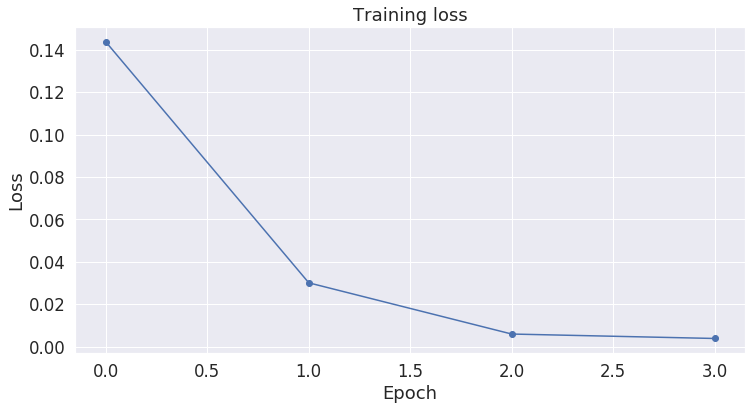

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### 4.5 saving the Model

In [23]:
import os

output_dir = './model_save/'

# Create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

### 4.6 Loading the model

In [0]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

## 5. performance evaluation

In [0]:
TEST_FILE = "created_data.csv"

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv(TEST_FILE)

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [28]:
# Prediction on test set
from tqdm import tqdm

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm(prediction_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

  0%|          | 0/102 [00:00<?, ?it/s]

Predicting labels for 3,250 test sentences...


100%|██████████| 102/102 [00:53<00:00,  2.20it/s]

    DONE.


In [0]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [32]:
from sklearn.metrics import classification_report
classification_report(flat_true_labels,flat_predictions)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      2000\n           1       0.99      1.00      1.00      1250\n\n    accuracy                           1.00      3250\n   macro avg       1.00      1.00      1.00      3250\nweighted avg       1.00      1.00      1.00      3250\n'

### On the training data it is doing excellent. But the real test will be on unseen data